# Preparacion de los datos

In [235]:
# Bibliotecas para Manipulación de Datos y Análisis
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Operaciones del sistema operativo
import os

# traduccion de texto
from googletrans import Translator

# Preprocesamiento y Escalado
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer

In [236]:
# Configuro los parámetros iniciales de matplotlib para estandarizar los gráficos
params = {
    'figure.figsize': (16, 10),  # Establezco el tamaño de cada gráfico
    'figure.dpi': 80,  # Configuro la resolución por pulgada
    'figure.facecolor': 'white',  # Defino el color de fondo
    'figure.edgecolor': 'white',  # Defino el color del borde
    'figure.frameon': True,  # Mantengo el borde del gráfico activado
    'figure.constrained_layout.use': False,  # Desactivo el diseño restringido para las figuras
    'figure.constrained_layout.h_pad': 0.04167,  # Espaciado horizontal en el diseño restringido
    'figure.constrained_layout.w_pad': 0.04167,  # Espaciado vertical en el diseño restringido
    'axes.labelsize': 12,  # Establezco el tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,  # Establezco el tamaño del título
    'axes.labelweight': 'normal',  # Configuro el grosor de la fuente de las etiquetas
    'xtick.labelsize': 10,  # Defino el tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,  # Defino el tamaño de las etiquetas del eje y
    'xtick.color': 'black',  # Configuro el color de las etiquetas del eje x
    'ytick.color': 'black',  # Configuro el color de las etiquetas del eje y
    'axes.spines.top': True,  # Mantengo visible el borde superior del gráfico
    'axes.spines.right': True,  # Mantengo visible el borde derecho del gráfico
    'legend.frameon': True,  # Mantengo visible el marco de la leyenda
    'grid.linestyle': '-',  # Defino el estilo de las líneas de la cuadrícula
    'grid.linewidth': 0.8,  # Configuro el grosor de las líneas de la cuadrícula
    'grid.color': 'gray',  # Establezco el color de las líneas de la cuadrícula
    'legend.fontsize': 10,  # Configuro el tamaño de la fuente de la leyenda
    'axes.titleweight': 'normal',  # Establezco el grosor de la fuente del título
    'axes.titlecolor': 'black',  # Configuro el color del título
    'axes.titlelocation': 'center',  # Coloco el título en el centro del gráfico
}

# Actualizo los parámetros de Matplotlib con la configuración establecida
plt.rcParams.update(params)

# Aplico el tema de tableau
plt.style.use('tableau-colorblind10')

# Activo la visualización de gráficos en línea (dentro de la celda de código)
%matplotlib inline

### Funcion para renombramiento de columnas

**snake_case**

In [237]:
def snake_case(column_name):
    column_name = column_name.lower()
    column_name = column_name.replace(' ', '_')
    return column_name

**Eliminar signos extraños**

In [238]:
def clean_signs(column_name, list_signs):
    for sign in list_signs:
        column_name = column_name.replace(sign, '')
    return column_name

**Texto a minusculas**

In [239]:
def text_to_lower(column):
    column = column.str.lower()
    return column

Traduccion de texto

In [240]:
def translate_unique_values(column, src='en', dest='es'):
    unique_values = column.unique()  # Obtener los valores únicos
    translations = {}

    # Traducir cada valor único
    for value in unique_values:
        if pd.notnull(value) and isinstance(value, str):
            try:
                translations[value] = translator.translate(value, src=src, dest=dest).text
            except Exception as e:
                print(f"Error al traducir {value}: {e}")
                translations[value] = value  # Mantener el valor original en caso de error
        else:
            translations[value] = value  # Mantener el valor original si es nulo o no es string

    # Reemplazar los valores originales con las traducciones
    return column.map(translations)

## Lectura de csv

In [241]:
df_path = '../data/1_bronze/shopping_behavior_updated.csv'
df = pd.read_csv(df_path)

In [242]:
# creo una copia del dataframe original que almacenare en un nuevo df de procesamiento
df_processed = df.copy()

In [243]:
df_processed.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


## Limpieza

### Valores nulos

Deteccion y visualizacion

In [244]:
# lista con convenciones de valores nulos en strings

common_na_strings = ["faltante", "NA", "N A", "N/A", "#N/A", "NA ", " NA", "N /A", "N / A", " N / A",
                     "N / A ", "na", "n a", "n/a", "na "," na", "n /a", "n / a", " a / a", "n / a ",
                     "NULO", "nulo", "", "?", "*", ".", " ", "  ", "-", "--", "---", "----", 
                     "MISSING", "Missing", "missing", "NULL", "null", "Null", "none", "None", "NONE",
                     "NaN", "nan", "NAN", "UNDEFINED", "undefined", "Undefined", "UNKNOWN", "unknown", 
                     "Unknown", "NOT AVAILABLE", "not available", "Not Available", "NOT APPLICABLE", 
                     "not applicable", "Not Applicable", "NOT GIVEN", "not given", "Not Given", 
                     "NOT RECORDED", "not recorded", "Not Recorded", "EMPTY", "empty", "Empty", 
                     "BLANK", "blank", "Blank", "NO DATA", "no data", "No Data", "-999", "-9999", 
                     "-1", "none available", "none provided", "not provided", "unavailable", 
                     "no value", "not specified", "unlisted", "no entry"]

In [245]:
# remplazo las posibles convenciones de valores nulos dentro del dataframe, por valores nulos np.nan detectados por numpy
df_processed = df_processed.replace(
    to_replace=common_na_strings,
    value=np.nan
)

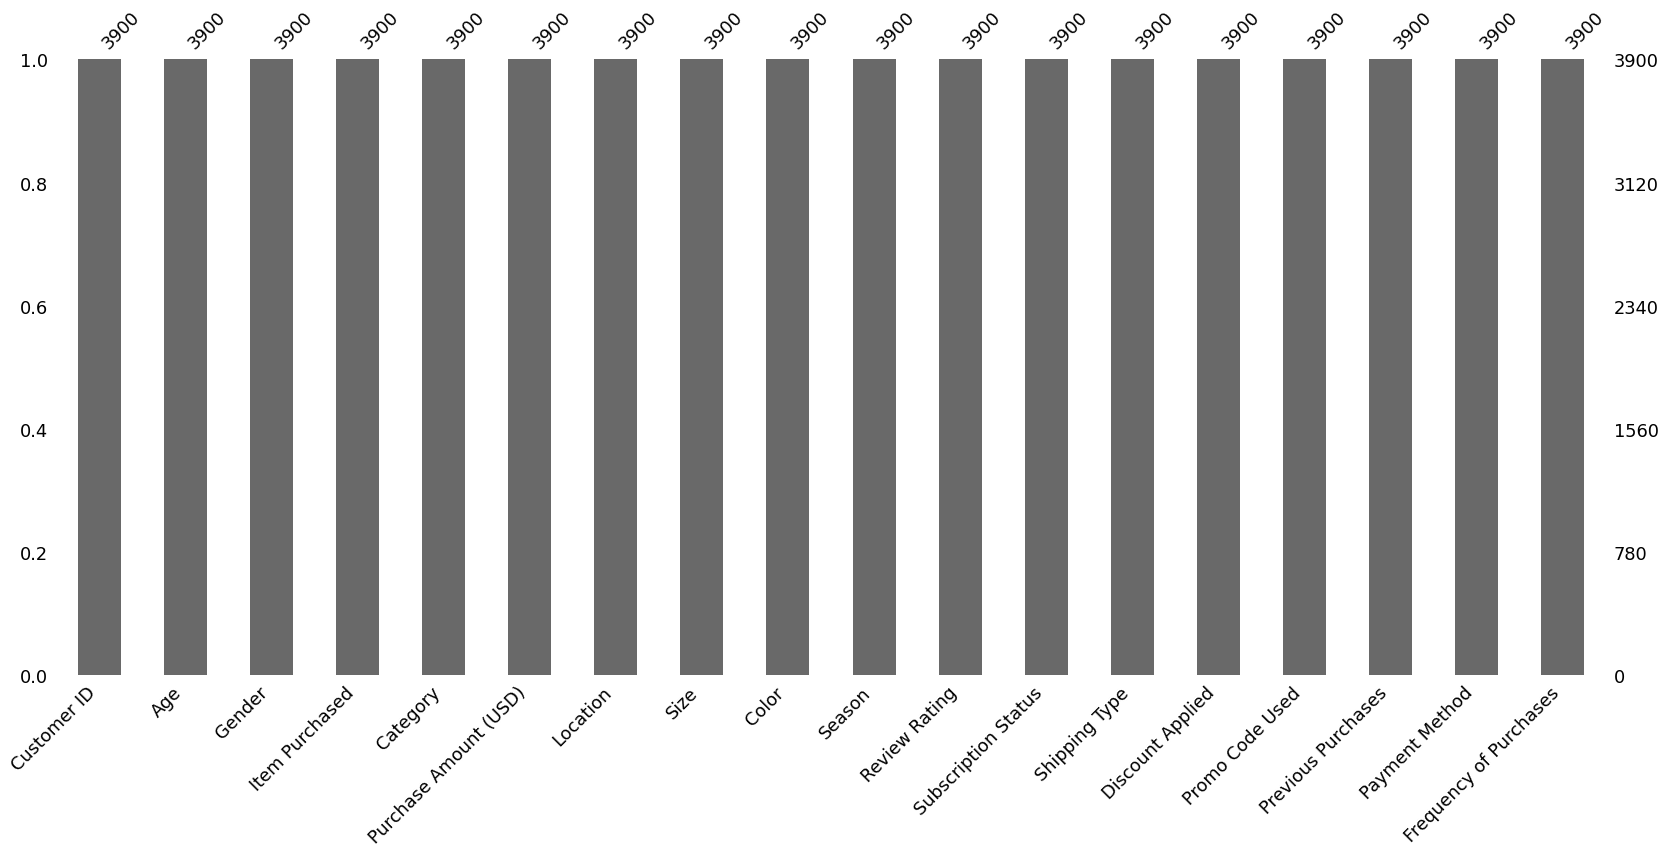

In [246]:
msno.bar(df_processed)
plt.show()

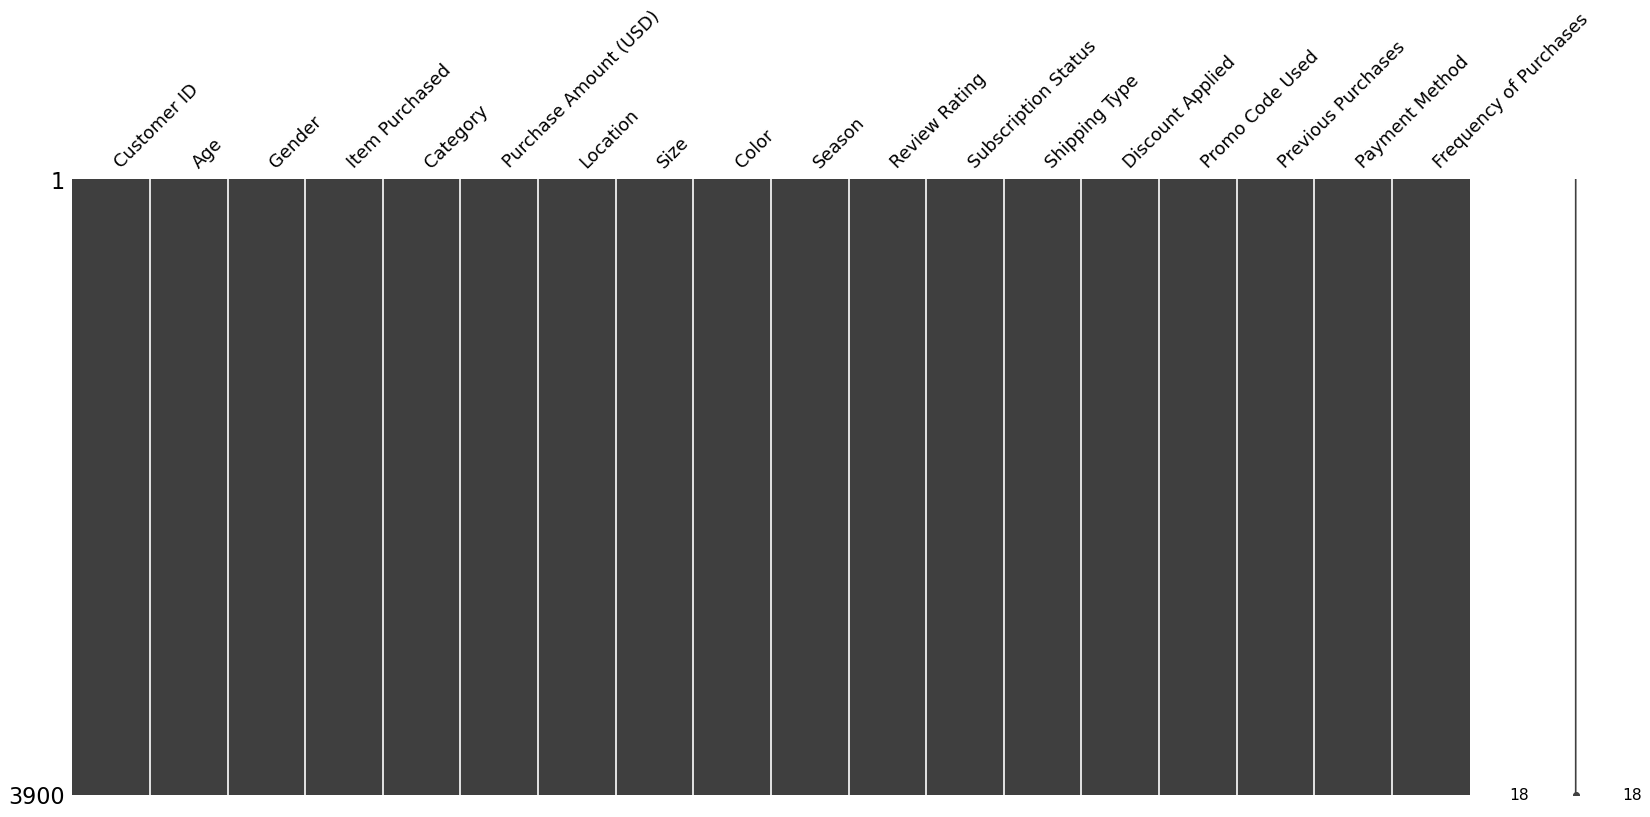

In [247]:
msno.matrix(df_processed)
plt.show()

In [248]:
df_processed.isnull().sum().sum()

0

### Obvervacion de esta sub-etapa:

- Agregar aqui -

## Ingenieria de caracteristicas

In [249]:
df_processed.sample(4)

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
2913,2914,43,Female,Coat,Outerwear,83,Wyoming,L,Cyan,Winter,3.5,No,Express,No,No,12,Cash,Every 3 Months
594,595,35,Male,Hoodie,Clothing,83,Oklahoma,S,Brown,Winter,2.5,Yes,Next Day Air,Yes,Yes,6,Debit Card,Monthly
2036,2037,37,Male,Blouse,Clothing,63,Minnesota,S,Lavender,Winter,3.1,No,Next Day Air,No,No,46,Cash,Weekly
724,725,37,Male,T-shirt,Clothing,79,New Hampshire,XL,Green,Fall,4.7,Yes,Store Pickup,Yes,Yes,36,Venmo,Every 3 Months


In [250]:
df_processed.dtypes

Customer ID                 int64
Age                         int64
Gender                     object
Item Purchased             object
Category                   object
Purchase Amount (USD)       int64
Location                   object
Size                       object
Color                      object
Season                     object
Review Rating             float64
Subscription Status        object
Shipping Type              object
Discount Applied           object
Promo Code Used            object
Previous Purchases          int64
Payment Method             object
Frequency of Purchases     object
dtype: object

### Seleccion manual de caracteristicas

In [251]:
df_processed.drop(columns='Discount Applied', inplace=True)

### Nombres de columnas

In [284]:
df_processed.rename(columns={'category':'category_item'}, inplace=True)

#### Estandarizacion y re-nombramiento

In [253]:
list_signs = ['(', ')']
columns = df_processed.columns

In [254]:
columns = list(map(snake_case, columns))
columns = list(map(lambda col: clean_signs(column_name=col, list_signs=list_signs), columns))

In [255]:
df_processed.columns = columns

### Valores tipo texto

In [256]:
df_processed[df_processed.select_dtypes(exclude='number').columns] = df_processed[df_processed.select_dtypes(exclude='number').columns].apply(text_to_lower)

Separacion de tipos de columnas

In [257]:
no_numbers_columns = df_processed.select_dtypes(exclude='number').columns 
number_columns = df_processed.select_dtypes(include='number').columns

Traduccion (aplicara en caso de una futura version)

In [258]:
'''
translator = Translator()

for col in df_processed[no_numbers_columns].columns:
    df_processed[col] = translate_unique_values(df_processed[col])

columns = pd.Series(df_processed.columns)
columns_es = translate_unique_values(columns)
df_processed.columns = columns_es
'''

Error al traducir male: 'NoneType' object has no attribute 'group'
Error al traducir female: 'NoneType' object has no attribute 'group'
Error al traducir blouse: 'NoneType' object has no attribute 'group'
Error al traducir sweater: 'NoneType' object has no attribute 'group'
Error al traducir jeans: 'NoneType' object has no attribute 'group'
Error al traducir sandals: 'NoneType' object has no attribute 'group'
Error al traducir sneakers: 'NoneType' object has no attribute 'group'
Error al traducir shirt: 'NoneType' object has no attribute 'group'
Error al traducir shorts: 'NoneType' object has no attribute 'group'
Error al traducir coat: 'NoneType' object has no attribute 'group'
Error al traducir handbag: 'NoneType' object has no attribute 'group'
Error al traducir shoes: 'NoneType' object has no attribute 'group'
Error al traducir dress: 'NoneType' object has no attribute 'group'
Error al traducir skirt: 'NoneType' object has no attribute 'group'
Error al traducir sunglasses: 'NoneTyp

### Tipos de datos

In [264]:
df_processed = df_processed.convert_dtypes(infer_objects=True)

**Datos cualitativos: nominales u ordinales**

In [265]:
df_processed.loc[df_processed['frequency_of_purchases']=='every 3 months', 'frequency_of_purchases'] = 'quarterly'
df_processed.loc[df_processed['frequency_of_purchases']=='fortnightly', 'frequency_of_purchases'] = 'bi-weekly'

In [266]:
df_processed[no_numbers_columns] = df_processed[no_numbers_columns].astype('category')

In [267]:
df_processed['customer_id'] = df_processed['customer_id'].astype('object')

**Datos cuantitativos**

Rangos o clases

In [268]:
bins = [0, 10, 12, 20, 60, 80, 110]
labels = ["niño", "preadolescente", "adolescente", "adulto", "tercera_edad", "cuarta_edad"]

df_processed['vital_stages'] = pd.cut(df_processed['age'], bins=bins, labels=labels, right=False)

### Codificacion de datos

Variables categoricas ordinales

In [269]:
# Definir un diccionario con las categorías en orden

ordinal_variables = {
    'size': ['s', 'm', 'l', 'xl'],
    'subscription_status': ['no', 'yes'],
    'promo_code_used': ['no', 'yes'],
    'frequency_of_purchases': ['weekly', 'bi-weekly', 'monthly', 'quarterly', 'annually'],
    'vital_stages': ['adolescente', 'adulto', 'tercera_edad'],
    'season': ['winter', 'spring', 'summer', 'fall']
}

Variables categoricas nominales

In [270]:
nominal_variables = df_processed.select_dtypes(include='category').columns
nominal_variables = [col for col in nominal_variables if col not in ordinal_variables.keys()]

In [271]:
df_nominal_encoded_variables = pd.DataFrame({})

# Inicializar el codificador
label_encoders = {col: LabelEncoder() for col in nominal_variables}

# Aplicar el codificador a las columnas nominales
for col in nominal_variables:
    df_nominal_encoded_variables[col] = label_encoders[col].fit_transform(df_processed[col])

In [272]:
# Crear el ColumnTransformer con las transformaciones
codification_ordinal_variables = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=list(ordinal_variables.values())), list(ordinal_variables.keys()))
    ]
)

In [273]:
ordinal_encoded_variables = codification_ordinal_variables.fit_transform(df_processed)
df_ordinal_encoded_variables = pd.DataFrame(ordinal_encoded_variables, 
                                            columns=codification_ordinal_variables.get_feature_names_out())

### Escalamiento de datos

In [274]:
# Crear el ColumnTransformer con las transformaciones
escalation_numerical_variables = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), number_columns)
    ]
)

In [275]:
# Escalar las variables numéricas
scaled_numerical_variables = escalation_numerical_variables.fit_transform(df_processed[number_columns].copy())
df_scaled_numerical_variables = pd.DataFrame(scaled_numerical_variables, columns=escalation_numerical_variables.get_feature_names_out(input_features=number_columns))

In [276]:
df_scaled_numerical_variables

,num__customer_id,num__age,num__purchase_amount_usd,num__review_rating,num__previous_purchases
0,-1.000000,0.423077,-0.166667,-0.461538,-0.44
1,-0.999487,-0.961538,0.095238,-0.461538,-0.92
2,-0.998974,0.230769,0.309524,-0.461538,-0.08
3,-0.998461,-0.884615,0.714286,-0.153846,0.96
4,-0.997948,0.038462,-0.261905,-0.769231,0.24
...,...,...,...,...,...
3895,0.997948,-0.153846,-0.761905,0.384615,0.28
3896,0.998461,0.307692,-0.261905,0.615385,0.64
3897,0.998974,0.076923,-0.642857,-0.615385,-0.04
3898,0.999487,0.000000,0.404762,0.076923,-0.04


In [277]:
# Concatenar los DataFrames
df_encoded_scaled = pd.concat([df_scaled_numerical_variables, df_ordinal_encoded_variables, df_nominal_encoded_variables], axis=1)

## Resultado final

### DataFrame para machine learning y correlaciones en EDA

In [278]:
df_encoded_scaled.sample(4, random_state=3)

,num__customer_id,num__age,num__purchase_amount_usd,num__review_rating,num__previous_purchases,ord__size,ord__subscription_status,ord__promo_code_used,ord__frequency_of_purchases,ord__vital_stages,ord__season,gender,item_purchased,category,location,color,shipping_type,payment_method
2990,0.533727,0.961538,0.738095,0.384615,-0.04,1.0,0.0,0.0,2.0,2.0,3.0,0,16,1,12,20,2,5
1314,-0.325981,-0.076923,0.166667,-0.230769,0.96,0.0,0.0,1.0,4.0,1.0,2.0,1,3,2,24,11,2,3
3265,0.674788,-0.153846,0.952381,-0.384615,0.12,1.0,0.0,0.0,1.0,1.0,0.0,0,22,0,0,23,1,2
3399,0.743524,-0.153846,-0.119048,-0.307692,0.44,3.0,0.0,0.0,4.0,1.0,0.0,0,13,1,25,24,4,3


In [279]:
path_encoded_scaled_dataset = '../data/2_silver/df_encoded_scaled.csv'
df_encoded_scaled.to_csv(path_encoded_scaled_dataset, index=False)

### DataFrame para bi

In [280]:
df_processed.sample(4, random_state=3)

,customer_id,age,gender,item_purchased,category,purchase_amount_usd,location,size,color,season,review_rating,subscription_status,shipping_type,promo_code_used,previous_purchases,payment_method,frequency_of_purchases,vital_stages
2990,2991,69,female,shirt,clothing,91,illinois,m,teal,fall,4.2,no,free shipping,no,24,venmo,monthly,tercera_edad
1314,1315,42,male,boots,footwear,67,missouri,s,magenta,summer,3.4,no,free shipping,yes,49,debit card,annually,adulto
3265,3266,40,female,sunglasses,accessories,100,alabama,m,white,winter,3.2,no,express,no,28,credit card,bi-weekly,adulto
3399,3400,40,female,pants,clothing,55,montana,xl,yellow,winter,3.3,no,standard,no,36,debit card,annually,adulto


In [281]:
# guardo los dataframes procesados y escalados en la carpeta "silver"
path_processed_dataset = '../data/3_gold/df_processed.csv'
df_processed.to_csv(path_processed_dataset, index=False)

In [294]:
df_processed.columns

Index(['customer_id', 'age', 'gender', 'item_purchased', 'category_item',
       'purchase_amount_usd', 'location', 'size', 'color', 'season',
       'review_rating', 'subscription_status', 'shipping_type',
       'promo_code_used', 'previous_purchases', 'payment_method',
       'frequency_of_purchases', 'vital_stages'],
      dtype='object')

In [300]:
df_processed['subscription_status'].unique()

['yes', 'no']
Categories (2, string): [no, yes]

In [306]:
df_processed.vital_stages.unique()

['adulto', 'adolescente', 'tercera_edad']
Categories (6, object): ['niño' < 'preadolescente' < 'adolescente' < 'adulto' < 'tercera_edad' < 'cuarta_edad']

In [283]:
# columna origial
# columna transfotmada
# tipo dato transformado
# variables transformadas

# Tabla de Transformación de Datos

| **Columna Original**           | **Columna Transformada**     | **Tipo de Dato Transformado** | **Variables Transformadas** |
|-------------------------------|------------------------------|-------------------------------|------------------------------|
| **Customer ID**               | `customer_id`                | `object`                      |                              |
| **Age**                       | `age`                        | `int64`                       |                              |
| **Gender**                    | `gender`                     | `category`                    | 'male', 'female'             |
| **Item Purchased**            | `item_purchased`             | `category`                    | 'blouse', 'sweater', 'jeans', 'sandals', 'sneakers', ..., 'socks', 'backpack', 'belt', 'boots', 'gloves' |
| **Category**                  | `category_item`              | `category`                    | 'clothing', 'footwear', 'outerwear', 'accessories' |
| **Purchase Amount (USD)**     | `purchase_amount_usd`        | `int64`                       |                              |
| **Location**                  | `location`                   | `category`                    | 'kentucky', 'maine', 'massachusetts', 'rhode island', 'oregon', ..., 'south dakota', 'minnesota', 'washington', 'wisconsin', 'michigan' |
| **Size**                      | `size`                       | `category`                    | 'l', 's', 'm', 'xl'          |
| **Color**                     | `color`                      | `category`                    | 'gray', 'maroon', 'turquoise', 'white', 'charcoal', ..., 'orange', 'indigo', 'yellow', 'magenta', 'blue' |
| **Season**                    | `season`                     | `category`                    | 'winter', 'spring', 'summer', 'fall' |
| **Review Rating**             | `review_rating`              | `float64`                     |                              |
| **Subscription Status**       | `subscription_status`        | `category`                    | 'yes', 'no'                  |
| **Shipping Type**             | `shipping_type`              | `category`                    | 'express', 'free shipping', 'next day air', 'standard', '2-day shipping', 'store pickup' |
| **Promo Code Used**           | `promo_code_used`            | `category`                    | 'yes', 'no'                  |
| **Previous Purchases**        | `previous_purchases`         | `int64`                       |                              |
| **Payment Method**            | `payment_method`             | `category`                    | 'venmo', 'cash', 'credit card', 'paypal', 'bank transfer', 'debit card' |
| **Frequency of Purchases**    | `frequency_of_purchases`     | `category`                    | 'bi-weekly', 'weekly', 'annually', 'quarterly', 'monthly' |
| -                             | `vital_stages`               | `category`                    | 'adulto', 'adolescente', 'tercera_edad' |